In [180]:
import pandas as pd
import numpy as np
import networkx as nx
import math
import requests
import urllib.request
from bs4 import BeautifulSoup
import bleach
import re
import matplotlib.pyplot as plt
%matplotlib inline
from fa2 import ForceAtlas2

## Data Extraction

We will build a network of main characters.

First we look into the wiki page https://gameofthrones.fandom.com/wiki/Game_of_Thrones_Wiki. There are a few wiki pages introducing main characters. We would like to include them in our network as nodes. However, each character may have many nicknames/alias. In order to achieve higher accuracy, we find out all possible nicknames/alias (tried my best and it is tedious). We build a dictionary with key = Full Name and value = list of nicknames.

In [117]:
def characterDic():
    nicknames={}
    nicknames["Jon Snow"] = ["Aegon Targaryen", "Aegon", "Lord Snow"]
    nicknames["Sansa Stark"] = ["Sansa",]
    nicknames["Arya Stark"] = ["Arya",]
    nicknames["Bran Stark"] = ["Three-Eyed Raven", "Bran", "Brandon"]
    nicknames["Edmure Tully"] = ["Edmure", ]
    nicknames["Davos Seaworth"] = ["The Onion Knight", "Ser Onion Knight", "Davos"]
    nicknames["Tormund"] = ["Tormund Giantsbane",]
    nicknames["Meera Reed"] = ["Meera", ]
    nicknames["Lyanna Mormont"] = ["Lyanna", ]
    nicknames["Benjen Stark"] = ["Benjen",]
    nicknames["Cersei Lannister"] = ["Cersei", ]
    nicknames["Jaime Lannister"] = ["Jaime", "Kingslayer"]
    nicknames["Tyrion Lannister"] = ["Imp", "Halfman", "Little Lion"]
    nicknames["Qyburn"] = ["Qyburn",]
    nicknames["Gregor Clegane"] = ["The Mountain", "Gregor"]
    nicknames["Bronn"] = ["Bronn",]
    nicknames["Tywin Lannister"] = ["Tywin",]
    nicknames["Joffrey Baratheon"] = ["Joffrey", "Joff"]
    nicknames["Myrcella Baratheon"] = ["Myrcella",]
    nicknames["Tommen Baratheon"] = ["Tommen",]
    nicknames["Daenerys Targaryen"] = ["Daenerys Stormborn", "Stormborn", "Dany", 
                                       "Mhysa", "Dragon Queen", "Khaleesi"]
    nicknames["Rhaegar Targaryen"] = ["Rhaegar",]
    nicknames["Varys"] = ["Spider", "Eunuch"]
    nicknames["Yara Greyjoy"] = ["Yara",]
    nicknames["Theon Greyjoy"] = ['Theon', "Reek"]
    nicknames["Missandei"] = ["Missandei",]
    nicknames["Grey Worm"] = ["Torgo Nudho",]
    nicknames["Olenna Tyrell"] = ["Redwyne", "Olenna"]
    nicknames["Ellaria Sand"] = ["Ellaria",]
    nicknames["Brienne of Tarth"] = ["Brienne", "Maid of Tarth"]
    nicknames["Podrick Payne"] = ["Podrick",]
    nicknames["Samwell Tarly"] = ["Sam", "Samwell", "Piggy"]
    nicknames["Gilly"] = ["Gilly",]
    nicknames["Gendry Baratheon"] = ["Gendry", "Clovis"]
    nicknames["Petyr Baelish"] = ["Littlefinger", "Petyr", "Baelish"]
    print("Yeah, my favorite male character Sandor Clegane!")
    nicknames["Sandor Clegane"] = ["Hound", "Sandor"]
    nicknames["Melisandre"] = ["Red Woman", "Red Witch"]
    nicknames["Euron Greyjoy"] = ["Euron", ]
    nicknames["Night King"] = ["Night King",]
    print("Wait, thats all characters featured in wiki page.")
    print("....")
    print("But, my FAVORITE female character IS NOT included!!!!!")
    return nicknames

In [119]:
characters=characterDic()

Yeah, my favorite male character Sandor Clegane!
Wait, thats all characters featured in wiki page.
....
But, my FAVORITE female character IS NOT included!!!!!


**Time to add my FAVORITE female character !**

In [120]:
characters["Margaery Tyrell"] = ["Margaery",]

**We will use web scraping to extract data**

In [142]:
def getText(character):
    if " " in character:
        character = re.sub(r" ", "_", character)
    
    url="https://gameofthrones.fandom.com/wiki/" + character # get base url
    
    response = requests.get(url) # request a server response
    
    soup = BeautifulSoup(response.text, "html.parser") # parse text from html
    
    para=soup.findAll('p') # find all paragraphs
    
    # clean the raw text
    res=[]
    for p in para:
        p = re.sub(r"<.+?>", "", str(p)) # remove all other tags e.g. <a href>
        p = re.sub(r"\[\d+?\]", " ", p)  # remove footnote label e.g. [1], [2]
        p = re.sub(r"\n", "", p)         # remove the nextline character
        p = re.sub(r"\xa0", u" ", p)     # remove empty space due to encoding
        
        if len(p) != 0 and p[-1] == " ": # remove empty space at the end, if present
            p = p[:-1]
        res.append(p)
        
    return "".join(res)

In [143]:
pages={key : getText(key) for key in characters.keys()}

In page A, if B is mentioned n times, add an edge with weight 2 from A to B.

In [191]:
def edgeWeight(pagesDic, namesDic):
    # key = (A,B), value = N
    # In wiki page of A, B is mentioned N times
    res_dic={}
    
    # loop through each character
    for name in namesDic:
        
        # obtain all his names/alias
        nameList=[name,] + namesDic[name]
        
        # loop through every wikipages
        for character in pagesDic:
            # prevent self loop --> Jon Snow page mentions Jon Snow himself N times
            if character != name:
                count=0
                # obtain the text
                text=pagesDic[character]
                
                # count for every mention of alias
                for alias in nameList:
                    count += text.count(alias)
                    
                # update result dictionary
                if count != 0:
                    res_dic[(character, name)]=count

    return res_dic

In [192]:
edgeWightDic=edgeWeight(pages,characters)

In [193]:
G=nx.DiGraph()
G.add_nodes_from(list(characters.keys()))
G.add_edges_from(list((k[0],k[1],{"weight" : v}) for (k,v) in edgeWightDic.items()))

In [195]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.0001,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.08,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=False)
positions = forceatlas2.forceatlas2_networkx_layout(G.to_undirected(), 
                                                    pos=None,iterations=10000)

In [223]:
nodeSize=[G.in_degree(weight="weight")[character] for character in G.nodes]

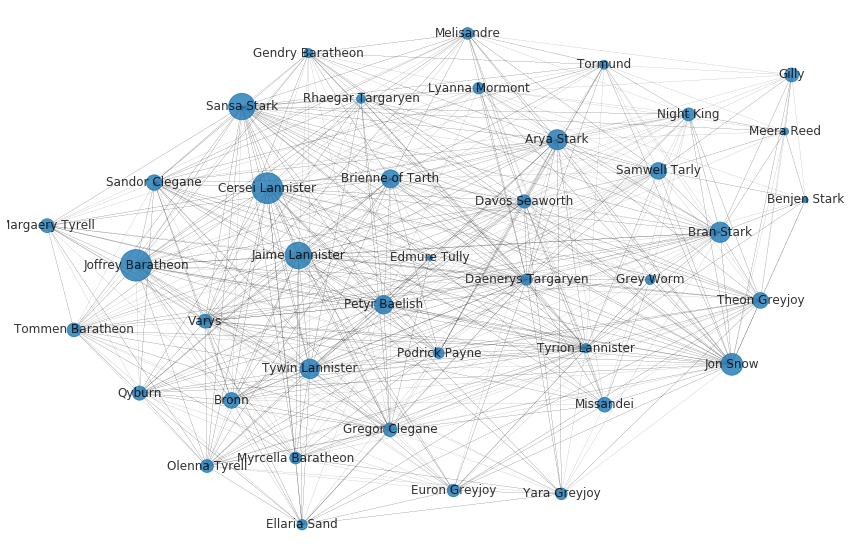

In [243]:
plt.figure(figsize=(15,10))
plt.axis("off")
nx.draw_networkx(G, positions, 
        node_size=[size/sum(nodeSize) * 10000 for size in nodeSize],
        node_shape='o',
        width=0.1, arrows=False, with_labels=True, alpha = 0.8)